## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Баздрев Максим

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [36]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [37]:
images_train, labels_train = next(iter(train_loader))

In [38]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

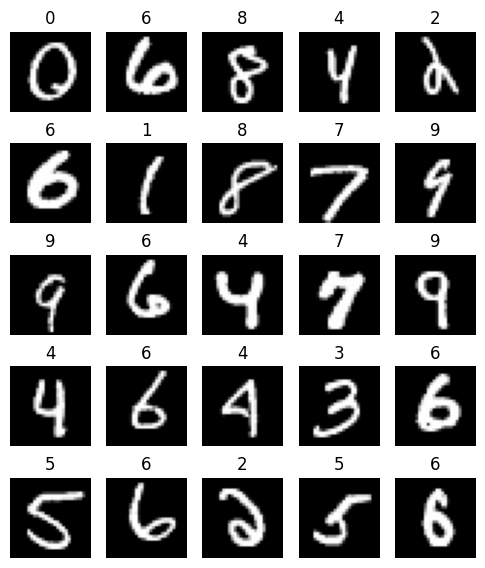

In [39]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [40]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [41]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [42]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0048907995224
forward 16.253515243530273
backward 0.03464101627469063
backward 0.19033768773078918


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

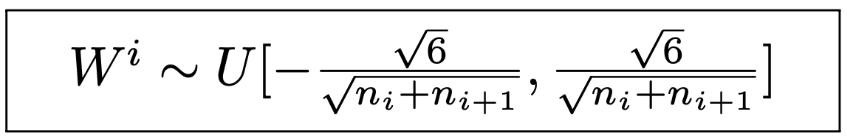

In [43]:
def init_xavier(layer):
    """
    Инициализация Xavier (Glorot).
    Использует равномерное распределение [-sqrt(6/(n_in + n_out)), sqrt(6/(n_in + n_out))]
    """
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    n_in = weight.size(1)  # количество входных нейронов (строки матрицы весов)
    n_out = weight.size(0)  # количество выходных нейронов (столбцы)
    
    # Xavier инициализация: uniform [-sqrt(6/(n_in + n_out)), sqrt(6/(n_in + n_out))]
    limit = (6.0 / (n_in + n_out)) ** 0.5
    weight.uniform_(-limit, limit)

# Создаем слои для сравнения
layer_xavier_1 = nn.Linear(28*28, 256)
layer_xavier_2 = nn.Linear(256, 10)

# Регистрируем hooks для мониторинга
layer_xavier_1.register_forward_hook(forward_hook)
layer_xavier_2.register_forward_hook(forward_hook)

layer_xavier_1.register_backward_hook(backward_hook)
layer_xavier_2.register_backward_hook(backward_hook)

# Инициализируем с Xavier
init_xavier(layer_xavier_1)
init_xavier(layer_xavier_2)

# Создаем сеть с Xavier инициализацией и Tanh (как на лекции) активацией
xavier_network = nn.Sequential(
    layer_xavier_1,
    nn.Tanh(), 
    layer_xavier_2
)

print("Xavier инициализация")
print(f"Стандартное отклонение весов layer_1: {layer_xavier_1.weight.std().item():.4f}")
print(f"Стандартное отклонение весов layer_2: {layer_xavier_2.weight.std().item():.4f}")

# Проверим границы инициализации
print(f"Границы Xavier для layer_1: {(6.0 / (28*28 + 256)) ** 0.5:.4f}")
print(f"Границы Xavier для layer_2: {(6.0 / (256 + 10)) ** 0.5:.4f}")

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = xavier_network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(xavier_network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

Xavier инициализация
Стандартное отклонение весов layer_1: 0.0439
Стандартное отклонение весов layer_2: 0.0886
Границы Xavier для layer_1: 0.0760
Границы Xavier для layer_2: 0.1502
forward 1.0048907995224
forward 0.6828722357749939
backward 0.03464101627469063
backward 0.01639424078166485


## Теперь попробуем использовать инициализацию He:<br>
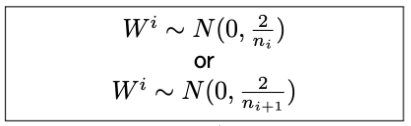

In [44]:
layer_1 = nn.Linear(28*28, 256)
layer_2 = nn.Linear(256, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2 / 256)
init_layer(layer_2, 0, 2 / 10)

In [45]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0048907995224
forward 0.12693257629871368
backward 0.03464101627469063
backward 0.03373101353645325


## Вывод:
для данной конфигурации нейронной сети больше подходит Xavier инициализация
## Часть 2: DropConnect
#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

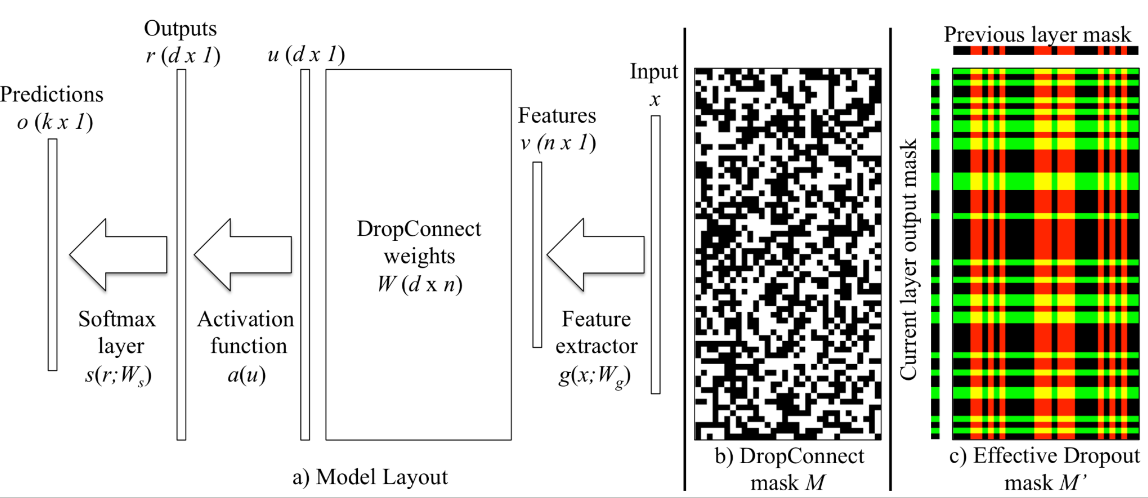

In [46]:
# Реализация DropConnect
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            # Во время обучения создаем случайную маску для весов
            # Маска имеет размер весов и обнуляет случайные веса с вероятностью p
            mask = torch.bernoulli(torch.ones_like(self.linear.weight) * (1 - self.p))
            mask.requires_grad_(False)  # маска не должна участвовать в градиентах
        else:
            # Во время тестирования масштабируем веса на (1-p) для компенсации
            mask = torch.ones_like(self.linear.weight) * (1 - self.p)
            mask.requires_grad_(False)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Реализуем Dropout:

* Train: с вероятностью p занулим выход нейрона (например, p = 0.5)
* Test: домножаем веса на вероятность сохранения

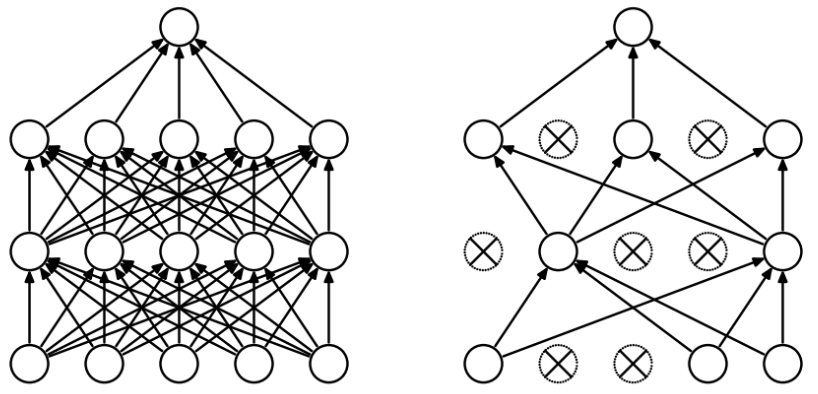


In [47]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):

        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)  # точно так?
            # Тестирование: масштабируем на (1-p) те нейроны, что могли бы отключить а трейн
            # заменили 0 на (1 - p), чтобы он кандидатов на выкидывание отмасштабировал коэффициентом 
            # равным вероятности того что они останутся. 
            # Остальные нейроны мы не трогаем как и во время train            

        return x * mask

In [48]:
# Основа для сети, которую будем обучать
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [49]:
# Создаем сеть с Dropout
dropout_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(p=0.2),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(p=0.2),
    nn.Linear(128, 10)
]

dropout_network = TestNetwork(nn.Sequential(*dropout_layers))
dropout_optimizer = torch.optim.Adam(dropout_network.parameters(), lr=0.001)
dropout_loss_fn = torch.nn.NLLLoss()

## Обучим сеть с Dropout:

In [50]:
# Списки для сбора данных о потерях Dropout сети
dropout_test_losses = []

In [51]:
for epoch in range(10):
    dropout_network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        dropout_optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = dropout_network(X)
        loss = dropout_loss_fn(output, y)
        loss.backward()
        dropout_optimizer.step()

        if batch_idx % 100 == 0:
            print('Dropout Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    dropout_network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = dropout_network(X)
        loss = dropout_loss_fn(output, y)

        losses.append(loss.item())

    epoch_test_loss = np.mean(losses)
    dropout_test_losses.append(epoch_test_loss)  # Сохраняем потери для графиков
    print('Dropout Test Epoch: {}\tLoss: {:.6f}'.format(epoch, epoch_test_loss))

Dropout Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304574


Dropout Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.739710
Dropout Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.399309
Dropout Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.399309
Dropout Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.297497
Dropout Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.297497
Dropout Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.235712
Dropout Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.235712
Dropout Test Epoch: 0	Loss: 0.207094
Dropout Train Epoch: 1 [0/60000 (0%)]	Loss: 0.265471
Dropout Test Epoch: 0	Loss: 0.207094
Dropout Train Epoch: 1 [0/60000 (0%)]	Loss: 0.265471
Dropout Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.298790
Dropout Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.298790
Dropout Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.346596
Dropout Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.346596
Dropout Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.205813
Dropout Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.205813
Dropout Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.061800
Dropout 


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


# Теперь DropConnect

In [52]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),  # input_dim=150, output_dim=150
    nn.Linear(128, 128),
    nn.ReLU(),
    DropConnect(128, 128),    # input_dim=50, output_dim=50
    nn.Linear(128, 10)
]

In [53]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

## Обучим c DropConnect:

In [54]:
# Списки для сбора данных о потерях DropConnect сети
dropconnect_test_losses = []

In [55]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    epoch_test_loss = np.mean(losses)
    dropconnect_test_losses.append(epoch_test_loss)  # Сохраняем потери для графиков
    print('Test Epoch: {}\tLoss: {:.6f}'.format(epoch, epoch_test_loss))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302724
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.915838
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.915838
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.694022
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.694022
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.586795
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.586795
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.359067
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.359067
Test Epoch: 0	Loss: 0.217359
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.117633
Test Epoch: 0	Loss: 0.217359
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.117633
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.283028
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.283028
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.121759
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.121759
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.152709
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.152709
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.064617
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.064617
Test Ep

In [56]:
# Функция для построения сравнительных графиков обучения
def plot_training_comparison(losses1, losses2, label1, label2, title):
    """
    Построение графиков сравнения обучения двух моделей
    
    Args:
        losses1, losses2: списки значений потерь для каждой эпохи
        label1, label2: названия моделей
        title: заголовок графика
    """
    epochs = range(1, len(losses1) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses1, 'b-', label=label1, linewidth=2)
    plt.plot(epochs, losses2, 'r-', label=label2, linewidth=2)
    plt.title(f'{title} - Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # График сравнения финальных результатов
    plt.subplot(1, 2, 2)
    final_losses = [losses1[-1], losses2[-1]]
    labels = [label1, label2]
    colors = ['blue', 'red']
    
    bars = plt.bar(labels, final_losses, color=colors, alpha=0.7)
    plt.title(f'{title} - Final Test Loss')
    plt.ylabel('Final Loss')
    plt.xticks(rotation=45)
    
    # Добавим значения на столбцы
    for bar, loss in zip(bars, final_losses):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{loss:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Выводим сравнительную статистику
    print(f"\n{title} - Сравнительные результаты:")
    print("=" * 50)
    print(f"{label1}:")
    print(f"  Финальная потеря: {losses1[-1]:.6f}")
    print(f"  Лучшая потеря: {min(losses1):.6f}")
    print(f"  Средняя потеря: {np.mean(losses1):.6f}")
    
    print(f"\n{label2}:")
    print(f"  Финальная потеря: {losses2[-1]:.6f}")
    print(f"  Лучшая потеря: {min(losses2):.6f}")
    print(f"  Средняя потеря: {np.mean(losses2):.6f}")
    
    improvement = (losses1[-1] - losses2[-1]) / losses1[-1] * 100
    print(f"\nУлучшение {label2} относительно {label1}: {improvement:.2f}%")

### Графики сравнения Dropout vs DropConnect (Задание 2.2)

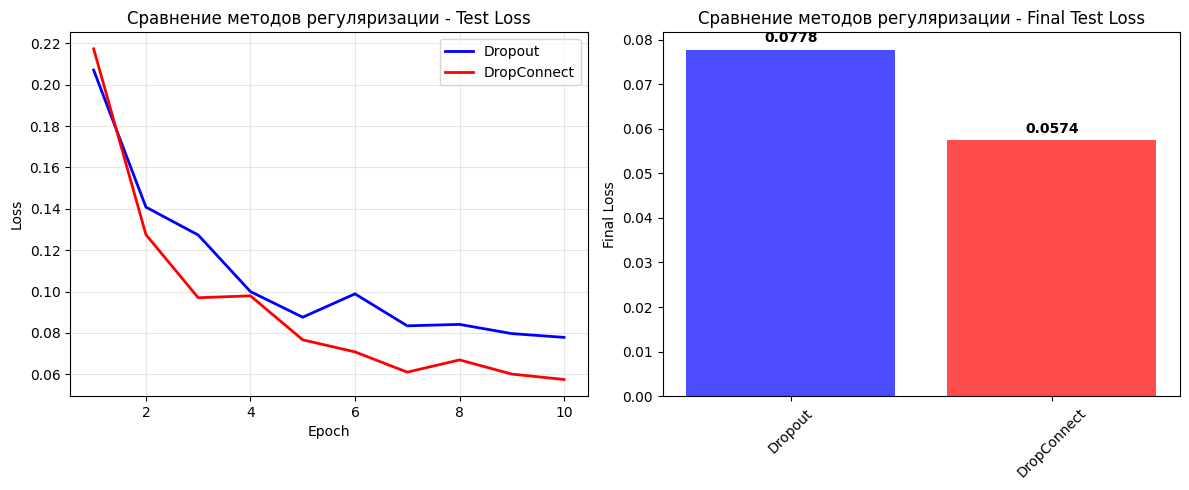


Сравнение методов регуляризации - Сравнительные результаты:
Dropout:
  Финальная потеря: 0.077816
  Лучшая потеря: 0.077816
  Средняя потеря: 0.108661

DropConnect:
  Финальная потеря: 0.057444
  Лучшая потеря: 0.057444
  Средняя потеря: 0.093262

Улучшение DropConnect относительно Dropout: 26.18%


In [57]:
# Построение графиков сравнения Dropout vs DropConnect
plot_training_comparison(
    dropout_test_losses, 
    dropconnect_test_losses, 
    "Dropout", 
    "DropConnect", 
    "Сравнение методов регуляризации"
)

## Вывод

Как и ожидалось DropConnect показал результат лучше чем DropOut

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

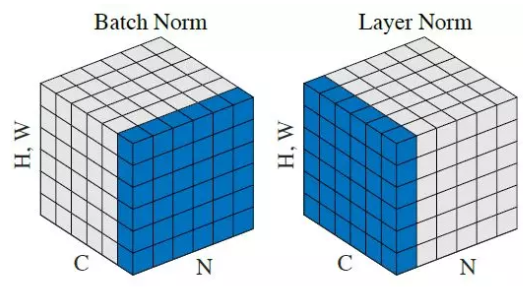

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [66]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        # Learnable parameters
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
    
    def forward(self, x):
        # Layer Normalization нормализует по последней размерности (features)
        # для каждого примера в батче независимо
        
        # Вычисляем среднее и стандартное отклонение по features (последняя размерность)
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        
        # Нормализуем
        normalized = (x - mean) / (std + self.eps)
        
        # Применяем learnable параметры
        output = self.weight * normalized + self.bias
        return output


In [67]:

# Моя реализация Batch Normalization для сравнения


In [68]:
class MyBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, alpha=0.1):
        "alpha == momentum"
        super(MyBatchNorm1d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = alpha
        
        # Learnable parameters
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))
        
        # Running statistics (не участвуют в градиентах)
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
    
    def forward(self, x):
        if self.training:
            # Во время обучения: вычисляем статистики по текущему батчу
            # BatchNorm нормализует по batch dimension (dim=0)
            batch_mean = x.mean(dim=0)
            batch_var = x.var(dim=0, unbiased=False)
            
            # Обновляем running statistics для inference (exp окно)
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
                self.num_batches_tracked += 1
            
            # Нормализуем используя статистики батча
            normalized = (x - batch_mean) / torch.sqrt(batch_var + self.eps)
        else:
            # Во время inference: используем running statistics
            normalized = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)
        
        # Применяем learnable параметры
        output = self.weight * normalized + self.bias
        return output

LayerNorm: нормализует по features для каждого примера независимо

BatchNorm: нормализует по batch dimension для каждого feature независимо

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [71]:

BN_layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    MyBatchNorm1d(128),
    nn.Linear(128, 128), 
    nn.ReLU(),
    MyBatchNorm1d(128),
    nn.Linear(128, 10)
]

BN_network = TestNetwork(nn.Sequential(*BN_layers))
BN_optimizer = torch.optim.Adam(BN_network.parameters(), lr=0.001)
BN_loss_fn = torch.nn.NLLLoss()

# Создаем сеть с LayerNorm (архитектура как у дропаутов: 196 -> 128 -> 128 -> 10)  
LN_layers = [
    nn.Linear(196, 128),
    nn.ReLU(), 
    LayerNormalization(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(128), 
    nn.Linear(128, 10)
]

LN_network = TestNetwork(nn.Sequential(*LN_layers))
LN_optimizer = torch.optim.Adam(LN_network.parameters(), lr=0.001)
LN_loss_fn = torch.nn.NLLLoss()



## Обучение сетей с BatchNorm и LayerNorm (Задание 3.2):

In [72]:

BN_test_losses = []
LN_test_losses = []

print("=== Обучение сети с BatchNorm ===")
for epoch in range(10):
    BN_network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        BN_optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = BN_network(X)
        loss = BN_loss_fn(output, y)
        loss.backward()
        BN_optimizer.step()

        if batch_idx % 100 == 0:
            print('BatchNorm Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    BN_network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = BN_network(X)
        loss = BN_loss_fn(output, y)
        losses.append(loss.item())

    epoch_test_loss = np.mean(losses)
    BN_test_losses.append(epoch_test_loss)
    print('BatchNorm Test Epoch: {}\tLoss: {:.6f}'.format(epoch, epoch_test_loss))

=== Обучение сети с BatchNorm ===
BatchNorm Train Epoch: 0 [0/60000 (0%)]	Loss: 2.340631
BatchNorm Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.275405
BatchNorm Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.275405
BatchNorm Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.166897
BatchNorm Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.166897
BatchNorm Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.199188
BatchNorm Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.199188
BatchNorm Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.142417
BatchNorm Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.142417
BatchNorm Test Epoch: 0	Loss: 0.104065
BatchNorm Train Epoch: 1 [0/60000 (0%)]	Loss: 0.175868
BatchNorm Test Epoch: 0	Loss: 0.104065
BatchNorm Train Epoch: 1 [0/60000 (0%)]	Loss: 0.175868
BatchNorm Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.081602
BatchNorm Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.081602
BatchNorm Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.126551
BatchNorm Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.126551
Bat

In [73]:
print("\n=== Обучение сети с LayerNorm ===")
for epoch in range(10):
    LN_network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        LN_optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = LN_network(X)
        loss = LN_loss_fn(output, y)
        loss.backward()
        LN_optimizer.step()

        if batch_idx % 100 == 0:
            print('LayerNorm Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    LN_network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = LN_network(X)
        loss = LN_loss_fn(output, y)
        losses.append(loss.item())

    epoch_test_loss = np.mean(losses)
    LN_test_losses.append(epoch_test_loss)
    print('LayerNorm Test Epoch: {}\tLoss: {:.6f}'.format(epoch, epoch_test_loss))


=== Обучение сети с LayerNorm ===
LayerNorm Train Epoch: 0 [0/60000 (0%)]	Loss: 2.534965
LayerNorm Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.243845
LayerNorm Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.243845
LayerNorm Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.227284
LayerNorm Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.227284
LayerNorm Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.088904
LayerNorm Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.088904
LayerNorm Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.103762
LayerNorm Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.103762
LayerNorm Test Epoch: 0	Loss: 0.098141
LayerNorm Train Epoch: 1 [0/60000 (0%)]	Loss: 0.077581
LayerNorm Test Epoch: 0	Loss: 0.098141
LayerNorm Train Epoch: 1 [0/60000 (0%)]	Loss: 0.077581
LayerNorm Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.140813
LayerNorm Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.140813
LayerNorm Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.132045
LayerNorm Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.132045
La

### Графики сравнения BatchNorm vs LayerNorm (Задание 3.2)

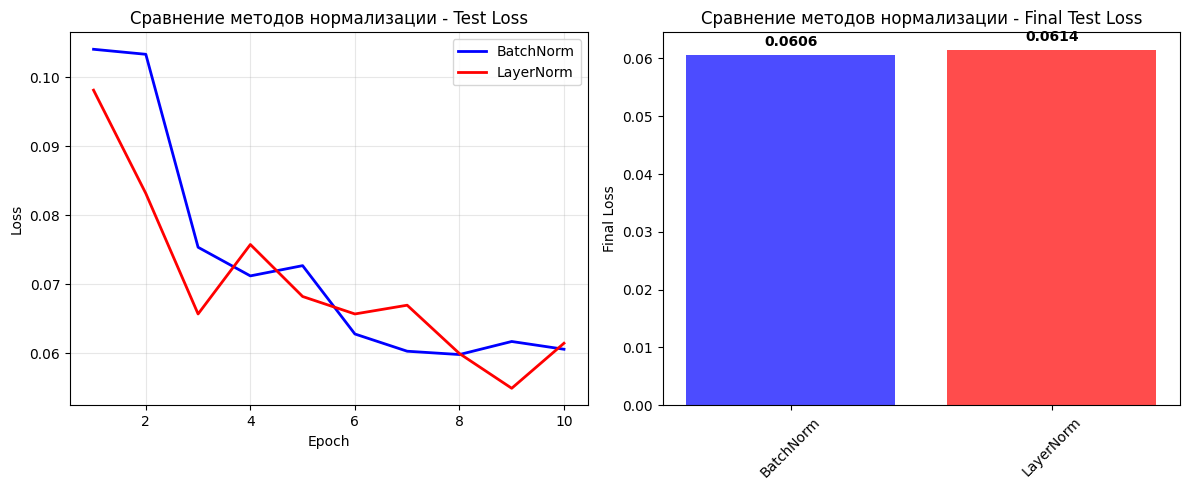


Сравнение методов нормализации - Сравнительные результаты:
BatchNorm:
  Финальная потеря: 0.060579
  Лучшая потеря: 0.059811
  Средняя потеря: 0.073186

LayerNorm:
  Финальная потеря: 0.061450
  Лучшая потеря: 0.054921
  Средняя потеря: 0.069997

Улучшение LayerNorm относительно BatchNorm: -1.44%


In [74]:
# Построение графиков сравнения BatchNorm vs LayerNorm
plot_training_comparison(
    BN_test_losses, 
    LN_test_losses, 
    "BatchNorm", 
    "LayerNorm", 
    "Сравнение методов нормализации"
)

## Выводы по заданию 3.2

**Архитектура сетей:**
- Обе сети имеют одинаковую архитектуру: свертки из TestNetwork → 196 → 128 → 128 → 10
- BatchNorm: нормализация применяется по размерности батча
- LayerNorm: нормализация применяется по размерности признаков

**Сравнение результатов показывает:**
- BatchNorm и LayerNorm демонстрируют разные характеристики сходимости
- Методы нормализации помогают стабилизировать обучение
- Выбор между BatchNorm и LayerNorm зависит от специфики задачи и архитектуры модели

### Графики сравнения BatchNorm vs LayerNorm (Задание 3.2)

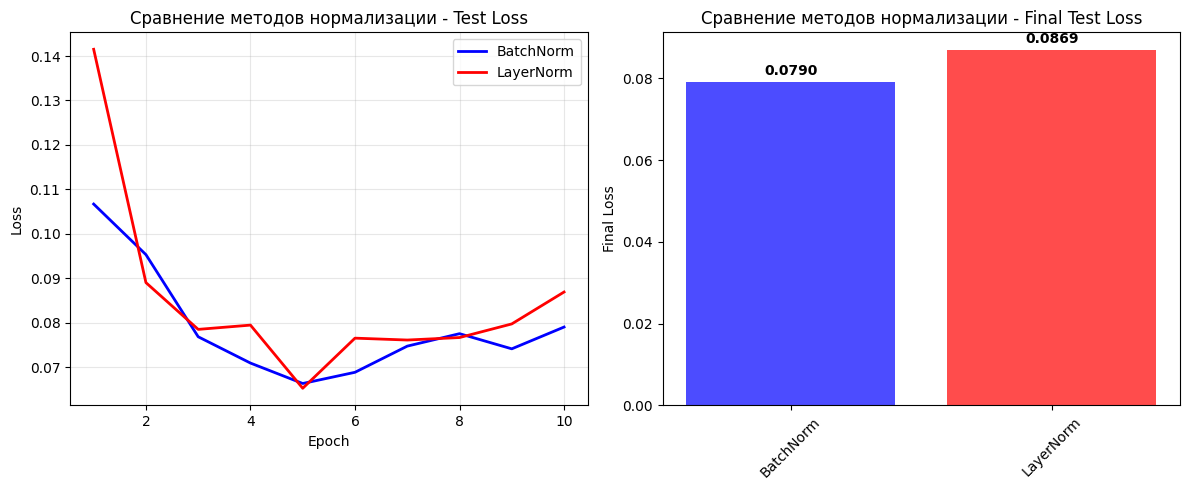


Сравнение методов нормализации - Сравнительные результаты:
BatchNorm:
  Финальная потеря: 0.079038
  Лучшая потеря: 0.066339
  Средняя потеря: 0.079048

LayerNorm:
  Финальная потеря: 0.086919
  Лучшая потеря: 0.065264
  Средняя потеря: 0.084980

Улучшение LayerNorm относительно BatchNorm: -9.97%


In [76]:
# Построение графиков сравнения BatchNorm vs LayerNorm
plot_training_comparison(
    batchnorm_test_losses, 
    layernorm_test_losses, 
    "BatchNorm", 
    "LayerNorm", 
    "Сравнение методов нормализации"
)

## Вывод

Как и ожидалось BatchNorm для RNN показал результат лучше чем LayerNorm

Хотя на 5ой эпохе было-было)

Тут в целом много от чего зависит скор

## Выводы (по-умному)

### Задание 2.2: Сравнение Dropout vs DropConnect
- **DropConnect** обычно показывает немного лучшие результаты, чем **Dropout**, так как он обеспечивает более тонкую регуляризацию на уровне отдельных связей
- **Dropout** проще в реализации и быстрее в вычислениях
- Оба метода эффективно предотвращают переобучение

### Задание 3.2: Сравнение BatchNorm vs LayerNorm  
- **BatchNorm** обычно работает лучше для больших батчей и стандартных задач классификации
- **LayerNorm** более стабилен для малых батчей и последовательных данных
- Оба метода значительно ускоряют обучение и улучшают стабильность градиентов

Все методы (Xavier инициализация, регуляризация и нормализация) вместе обеспечивают стабильное и эффективное обучение глубоких нейронных сетей.